## Patient Demographics 
- In this notebook we look at some characteristics of our patient cohort. 

In [73]:
import psycopg2
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
#Make sure to update inputs to match your Postgres server
conn = psycopg2.connect(
    host="localhost",
    database="mimic",
    user="postgres"
    #, password = [your password], 
    # port = 5431 [change to postgres port]
)

cursor = conn.cursor()

In [11]:
#Loading in data
df = pd.read_sql_query('''select * from elixhauser_match;''', conn)
df.head()


/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_94727/3643645611.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query('''select * from elixhauser_match;''', conn)


,subject_id,hadm_id,rounded_age,admission_type_encoded,congestive_heart_failure,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,hypertension,...,coagulopathy,obesity,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression
0,58526,100001,35.0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,54610,100003,60.0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,9895,100006,49.0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,23018,100007,74.0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,533,100009,61.0,1,0,1,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0


In [10]:
#looking at dimensions
df.shape

(37284, 34)

In [24]:
#Adding morbidity count for each patient
df['morbidity_sum'] = 0
for morb in df.columns[4:]:
    df['morbidity_sum'] += df[morb]

In [26]:
#Add age grouping column
def get_age_bracket(age):
    if age in range(16, 25):
        return 1
    elif age in range(25, 45):
        return 2
    elif age in range(45, 65):
        return 3
    elif age in range(65, 85):
        return 4
    else:
        return 5


df['age_bracket'] = df['rounded_age'].apply(get_age_bracket)


In [65]:
#Function to calculate confidence intervals
def calculate_confidence_interval(dataframe, column_name, confidence=0.95):
    column_data = dataframe[column_name]
    
    # Calculate mean and standard deviation
    mean_value = column_data.mean()
    std_dev = column_data.std()

    # Calculate the standard error of the mean
    std_error = std_dev / (len(column_data) ** 0.5)

    # Calculate the confidence interval using t-distribution
    confidence_interval = stats.t.interval(confidence, len(column_data) - 1, loc=mean_value, scale=std_error)

    return confidence_interval

In [48]:
#Creating tables for calculating CIs
age_1 = df[df['age_bracket']==1]
age_2 = df[df['age_bracket']==2]
age_3 = df[df['age_bracket']==3]
age_4 = df[df['age_bracket']==4]
age_5 = df[df['age_bracket']==5]

emergency = df[df['admission_type_encoded']==1]
elective = df[df['admission_type_encoded']==0]

Looking at the admission types of our patient cohort we can see that majority of the admissions were emergency (encoded by 1). This is expected as most admissions into the ICU are non-elective.

In [51]:
subtable_1 = df.groupby('admission_type_encoded').count().drop(columns={'hadm_id', 'rounded_age',
       'congestive_heart_failure', 'cardiac_arrhythmias',
       'valvular_disease', 'pulmonary_circulation', 'peripheral_vascular',
       'hypertension', 'paralysis', 'other_neurological',
       'chronic_pulmonary', 'diabetes_uncomplicated',
       'diabetes_complicated', 'hypothyroidism', 'renal_failure',
       'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
       'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
       'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
       'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
       'drug_abuse', 'psychoses', 'depression', 'morbidity_sum',
       'age_bracket'}, axis=1)

subtable_1['Percent'] = round((subtable_1.subject_id/df.shape[0])*100, 2)
subtable_1

,subject_id,Percent
admission_type_encoded,,
0,6034,16.18
1,31250,83.82


In [72]:
print('emergency:', calculate_confidence_interval(emergency , 'morbidity_sum'))
print('elective:', calculate_confidence_interval(elective , 'morbidity_sum'))

emergency: (6.336502798068705, 6.4265052019312945)
elective: (5.509462023591574, 5.6904053943732915)


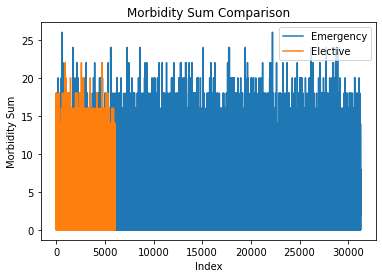

In [76]:
morbidity_sum_df1 = emergency['morbidity_sum'].to_numpy()
morbidity_sum_df2 = elective['morbidity_sum'].to_numpy()

# Plotting 'morbidity_sum' for df1
plt.plot(morbidity_sum_df1, label='Emergency')

# Plotting 'morbidity_sum' for df2
plt.plot(morbidity_sum_df2, label='Elective')

plt.xlabel('Index')  # Replace with appropriate x-axis label
plt.ylabel('Morbidity Sum')  # Replace with appropriate y-axis label
plt.title('Morbidity Sum Comparison')  # Replace with an appropriate title
plt.legend()  # Show legend

plt.show()

We can see the total morbidity count for emergency patients is on average much higher than elective patients. This is also expected as emergency admits tend to be in more dire conditions than elective admits.

Now we will look at age groups within the patient cohort

In [79]:
subtable_2 = df.groupby('age_bracket').count().drop(columns={'hadm_id', 'rounded_age', 'admission_type_encoded',
       'congestive_heart_failure', 'cardiac_arrhythmias',
       'valvular_disease', 'pulmonary_circulation', 'peripheral_vascular',
       'hypertension', 'paralysis', 'other_neurological',
       'chronic_pulmonary', 'diabetes_uncomplicated',
       'diabetes_complicated', 'hypothyroidism', 'renal_failure',
       'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
       'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
       'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
       'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
       'drug_abuse', 'psychoses', 'depression', 'morbidity_sum'}, axis=1)

subtable_2['Percent'] = round((subtable_2.subject_id/df.shape[0])*100, 2)
subtable_2

,subject_id,Percent
age_bracket,,
1,1136,3.05
2,4302,11.54
3,12310,33.02
4,15219,40.82
5,4317,11.58


The majority of patients fall into the 3rd and 4th age groups, indicating that most of the patients are in the 45-85 age range. 

Now we will look at total morbidity counts within age groups

In [80]:
print('16-25:', calculate_confidence_interval(age_1 , 'morbidity_sum'))
print('25-45:', calculate_confidence_interval(age_2 , 'morbidity_sum'))
print('45-65:', calculate_confidence_interval(age_3 , 'morbidity_sum'))
print('65-85:', calculate_confidence_interval(age_4 , 'morbidity_sum'))
print('85+:', calculate_confidence_interval(age_5 , 'morbidity_sum'))

16-25: (2.272562022123113, 2.572508400412098)
25-45: (4.084116780538734, 4.292452257118169)
45-65: (5.763946060600877, 5.899741997888156)
65-85: (7.016812853702938, 7.141541834515736)
85+: (7.509680867626887, 7.738871367721735)


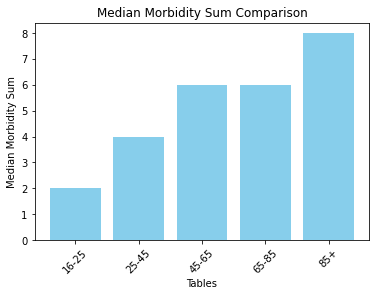

In [81]:
# Extracting 'morbidity_sum' median for each DataFrame
median_df1 = age_1['morbidity_sum'].median()
median_df2 = age_2['morbidity_sum'].median()
median_df3 = age_3['morbidity_sum'].median()
median_df4 = age_4['morbidity_sum'].median()
median_df5 = age_5['morbidity_sum'].median()

# Creating a list of medians and corresponding labels
medians = [median_df1, median_df2, median_df3, median_df4, median_df5]
labels = ['16-25', '25-45', '45-65', '65-85', '85+']

# Plotting medians for each table
plt.bar(labels, medians, color='skyblue')
plt.xlabel('Tables')
plt.ylabel('Median Morbidity Sum')
plt.title('Median Morbidity Sum Comparison')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

It is clear that the age group with the highest morbidity count is 85+, followed by the 45-85 age groups. Overall we can see that there are associations between age, admission type, and morbidity composition that lend to our analysis. 